In [1]:
import json
from collections import defaultdict
import ROOT

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x642fe50


In [2]:
ROOT.EnableImplicitMT(12)

In [3]:
def process_path(path: str) -> str:
    dir, _, fname = path.rpartition("/")
    # the mc-2020 filenames follow a certain fixed naming scheme, example:
    # rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I500102.P4f_sze_sl.eL.pR.n024.d_dstm_15180_122_mini-DST.edm4hep.root
    # <reco v>.<sim v>.<det model>.<machine setting>.<some id>.<process name>.<e pol>.<p pol>.<... other stuff
    parts = fname.split(".")
    process_name = parts[5].lstrip("P")
    e_pol = parts[6]
    p_pol = parts[7]
    return process_name, e_pol, p_pol

In [4]:
from collections import namedtuple
Stats = namedtuple("Stats", ["int_lumi", "n_events"])

# Petroff 10 color scheme backport
kP10 = [
ROOT.TColor( 63./255., 144./255., 218./255.),# "kP10Blue"),
ROOT.TColor(       1., 169./255.,  14./255.),# "kP10Yellow"),
ROOT.TColor(189./255.,  31./255.,   1./255.),# "kP10Red"),
ROOT.TColor(131./255.,  45./255., 182./255.),# "kP10Violet"),
ROOT.TColor(169./255., 107./255.,  89./255.),# "kP10Brown"),
ROOT.TColor(231./255.,  99./255.,        0.),# "kP10Orange"),
ROOT.TColor(185./255., 172./255., 112./255.),# "kP10Green"),
ROOT.TColor(113./255., 117./255., 129./255.),# "kP10Ash"),
ROOT.TColor(148./255., 164./255., 162./255.),# "kP10Gray"),
ROOT.TColor(146./255., 218./255., 221./255.),# "kP10Cyan")
]

class Dataset:
    """Initialise a dataset from a list of file paths in ILD mc-2020 production notation"""
    # we want to have something like {"process": {"pol: [path1, path2]"}}
    _dataset = defaultdict(lambda: defaultdict(list))

    # TODO use better typed input
    def __init__(self, input_path: str):
        with open(input_path) as file:
            for line in file:
                path = line.strip()
                self.add_file(path)


    def get_dataset(self):
        # convert back to regular dict
        return dict(self._dataset)

    # you probably do not want to call this yourself
    # I will probably put in stuff soon that assumes to only be called once the Dataset is complete
    # but no explicit checks...
    def add_file(self, path: str):
        process_name, e_pol, p_pol = process_path(path)
        self._dataset[process_name][e_pol + p_pol].append(path)

    def get_files(self, process_name: str, pol: str) -> list[str]:
        # use the getter to not have a defaultdict anymore and just let the dict throw
        return self.get_dataset()[process_name][pol]

    def get_keys(self):
        return [(process_name, pol) for process_name in self._dataset.keys() for pol in self._dataset[process_name].keys()]

    def get_merged_keys(self):
        return [f"{process_name}_{pol}" for process_name in self._dataset.keys() for pol in self._dataset[process_name].keys()]

class Analysis:
    """Holds a Dataset, all the data frames and possibly also all the histograms"""

    # _df: dict[str, ROOT.RDataFrame]
    _df = {}
    _stats: dict[str, Stats] = {}
    _histograms = {}
    _weights = {}
    _stacks = {}
    _canvases = {}
    # need a place to "park" them somewhere as the THStacks do not take ownership :(
    _scaled_histograms = {}
    _legends = {}

    def __init__(self, dataset: Dataset):
        self._dataset = dataset
        for process, pol in dataset.get_keys():
            files = dataset.get_files(process, pol)
            df = ROOT.RDataFrame("events", files)
            self._df[f"{process}_{pol}"] = df

    def Define(self, *args):
        for k in self._df:
            self._df[k] = self._df[k].Define(*args)


    def init_parameters(self, params: list[tuple[str, str]]):
        """Inits the podio generic parameters supplied as a list of (name, c++ typename)"""
        ROOT.gInterpreter.Declare("#include <podio/GenericParameters.h>")
        self.Define("Parameters", "podio::GenericParameters par; par.loadFrom(GPDoubleKeys, GPDoubleValues); par.loadFrom(GPFloatKeys, GPFloatValues); par.loadFrom(GPIntKeys, GPIntValues); par.loadFrom(GPStringKeys, GPStringValues); return par;")
        for p_name, p_type in params:
            self.Define(f"params_{p_name.replace('.', '_')}", f"Parameters.get<{p_type}>(\"{p_name}\").value()")


    # TODO: needs initParameters to be called first and with ("crossSection", "float") in the parameter list
    def book_statistics(self):
        self.Define("lumi", "1.0 / params_crossSection")
        # loop over all df, maybe also wrap this in the future
        for k in self._df:
            df = self._df[k]
            lumi = df.Sum("lumi")
            count = df.Count()
            self._stats[k] = Stats(int_lumi=lumi, n_events=count)


    def print_stats(self):
        for k in self._stats:
            stats = self._stats[k]
            print(f"process: {k} events: {stats.n_events.GetValue()} int lumi: {stats.int_lumi.GetValue()}")


    def get_keys(self):
        return self._dataset.get_merged_keys()


    def book_histogram_1D(self, name: str, column: str, config: tuple):
        histograms = {}
        for k in self._df:
            histograms[k] = self._df[k].Histo1D(config, column)
        self._histograms[name] = histograms


    def _calculate_lumi_weight(self, k: str, int_lumi: float):
        return int_lumi / self._stats[k].int_lumi.GetValue()


    def _calculate_pol_weight(self, k: str, e_pol: float, p_pol: float):
        process_e_pol = -1.0 if "eL" in k else 1.0 if "eR" in k else 0.0
        process_p_pol = -1.0 if "pL" in k else 1.0 if "pR" in k else 0.0

        return 0.25 * (1.0 + e_pol * process_e_pol) * (1.0 + p_pol * process_p_pol)


    def _calculate_weight(self, k: str, int_lumi: float, e_pol: float, p_pol: float):
        lumi_weight = self._calculate_lumi_weight(k, int_lumi)
        pol_weight = self._calculate_pol_weight(k, e_pol, p_pol)
        return lumi_weight * pol_weight


    def get_top_n(self, n: int, int_lumi: float, e_pol: float, p_pol: float):
        """Get the keys of the 10 processes with the current (after cuts) highest count * weight. Triggers event loop"""
        return self.get_sorted_keys(int_lumi, e_pol, p_pol)[:n]


    def get_sorted_keys(self, int_lumi: float, e_pol: float, p_pol: float):
        """Get the keys of the processes sorted by the current (after cuts) highest count * weight. Triggers event loop"""
        # FIXME: this recounts every time but we only need to recount if there actually was a filter
        # No clue yet how much this slows anything or if root nicely caches the result for us anyway...
        booked_counts = [(key, df.Count()) for key, df in self._df.items()]
        weighted_counts = [(key, count.GetValue() * self._calculate_weight(key, int_lumi, e_pol, p_pol)) for key, count in booked_counts]
        from operator import itemgetter
        weighted_counts.sort(key=itemgetter(1), reverse=True)
        return [key for key, _ in weighted_counts]


    def draw_histogram(self, name: str, int_lumi: float = 5000, e_pol: float = 0.0, p_pol: float = 0.0):
        histograms = self._histograms[name]
        stack = ROOT.THStack()
        params = (name, int_lumi, e_pol, p_pol)
        self._scaled_histograms[params] = {}
        legend = ROOT.TLegend(0.6, 0.7, 1., 1,)
        for i, k in enumerate(self.get_sorted_keys(int_lumi, e_pol, p_pol)):
            # this will trigger the computation
            h = histograms[k].Clone()
            weight = self._calculate_weight(k, int_lumi, e_pol, p_pol)
            h.Scale(weight)
            if i < 9:
                h.SetFillColor(kP10[i].GetNumber())
                # TODO: parse k to nice process name
                legend.AddEntry(h, k, "f")
            else:
                h.SetFillColor(kP10[9].GetNumber())
            stack.Add(h)
            # store h so that it does not get deleted
            self._scaled_histograms[params][k] = h
        # use the smallest (last) to attach as other to legend
        h_other = self._scaled_histograms[params][k]
        legend.AddEntry(h_other, "other", "f")
        legend.SetNColumns(2)
        self._legends[params] = legend
        self._stacks[params] = stack
        canvas = ROOT.TCanvas()
        self._canvases[params] = canvas
        stack.SetTitle(f";{name}")
        stack.Draw("hist")
        legend.Draw()
        canvas.Draw()



    # TODO: Add a method to store selected histograms to a root file
    # TODO: Add a method to snapshot parts of the data frames?





In [5]:
# dataset = Dataset("data/locations/miniDSTs/processed-no-higgs.txt")
dataset = Dataset("data/locations/miniDSTs/processed-test.txt")

print(dataset.get_keys())

print(json.dumps(dataset.get_dataset(), indent=2))

# print(dataset.get_files("4f_sw_sl", "eLpR"))

[('6f_llxyyx', 'eLpR'), ('4f_sw_l', 'eLpR'), ('aa_2f_z_l', 'eWpB'), ('aa_2f_z_l', 'eBpW'), ('aa_4f_zz_sl', 'eBpB'), ('4f_zz_h', 'eLpR'), ('4f_zz_h', 'eRpL'), ('4f_zz_sl', 'eLpR'), ('e1e1h', 'eLpR'), ('e1e1h', 'eRpR'), ('e1e1h', 'eLpL'), ('4f_sw_sl', 'eLpR'), ('4f_sw_sl', 'eRpL'), ('n1n1h', 'eLpR'), ('n1n1h', 'eRpL'), ('4f_zz_l', 'eLpR'), ('4f_sze_sl', 'eRpL'), ('4f_sze_sl', 'eLpR'), ('qqh', 'eLpR'), ('qqh', 'eRpL'), ('e2e2h', 'eLpR'), ('6f_vvyyyy', 'eRpL'), ('4f_sznu_l', 'eLpR'), ('ae_3f_z_l', 'eBpL'), ('2f_z_h', 'eLpR'), ('n23n23h', 'eRpL'), ('aa_2f_z_h', 'eBpW'), ('aa_2f_z_h', 'eWpB'), ('6f_llyyyy', 'eRpL'), ('4f_sznu_sl', 'eLpR')]
{
  "6f_llxyyx": {
    "eLpR": [
      "/eos/experiment/clicdp/data/user/l/lreichen/miniDST/6f/l5_o1/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402301.P6f_llxyyx.eL.pR.n000.d_dstm_15642_0_mini-DST.edm4hep.root"
    ]
  },
  "4f_sw_l": {
    "eLpR": [
      "/eos/experiment/clicdp/data/user/l/lreichen/miniDST/sw_l_analysis/l5_o1/rv02-02.sv02-02.mILD_l5_o1_v0

In [6]:
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
analysis = Analysis(dataset)

analysis.init_parameters([("crossSection", "float")])
analysis.book_statistics()
analysis.Define("n_isomuons", "IsolatedMuons_objIdx.size()")

In [7]:
analysis.book_histogram_1D("n_isomuons", "n_isomuons", ("", ";n_isomuons", 5, 0., 5.))

In [8]:
analysis.print_stats()

process: 6f_llxyyx_eLpR events: 9200 int lumi: 7762.739647267225
process: 4f_sw_l_eLpR events: 97200 int lumi: 28.404697187991253
process: aa_2f_z_l_eWpB events: 54000 int lumi: 0.013895946764627945
process: aa_2f_z_l_eBpW events: 54000 int lumi: 0.013942499196853952
process: aa_4f_zz_sl_eBpB events: 600 int lumi: 528.0898619404469
process: 4f_zz_h_eLpR events: 47000 int lumi: 33.45053031423902
process: 4f_zz_h_eRpL events: 18800 int lumi: 30.986808993219846
process: 4f_zz_sl_eLpR events: 46800 int lumi: 55.84195986131913
process: e1e1h_eLpR events: 17600 int lumi: 995.9544092569944
process: e1e1h_eRpR events: 9200 int lumi: 14755.757426854743
process: e1e1h_eLpL events: 9200 int lumi: 14755.757426854741
process: 4f_sw_sl_eLpR events: 84800 int lumi: 8.261873627067866
process: 4f_sw_sl_eRpL events: 10200 int lumi: 117.65228093821605
process: n1n1h_eLpR events: 18200 int lumi: 301.5696978829659
process: n1n1h_eRpL events: 9800 int lumi: 456.5741007737644
process: 4f_zz_l_eLpR events: 41

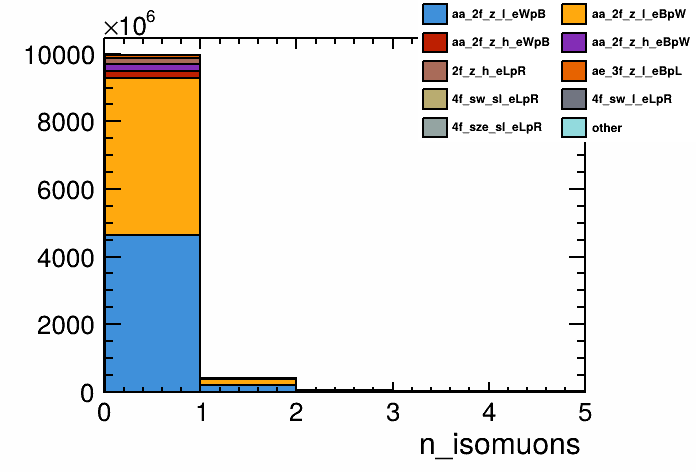

In [9]:
# %jsroot on
analysis.draw_histogram("n_isomuons")